# 地震データの分析
過去一か月間の世界中での地震で放出された地震エネルギー量を調べることで単にマグニチュードを見るよりも地震の影響の大きさを定量的に比較すること


In [3]:
%pip install pandas requests

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


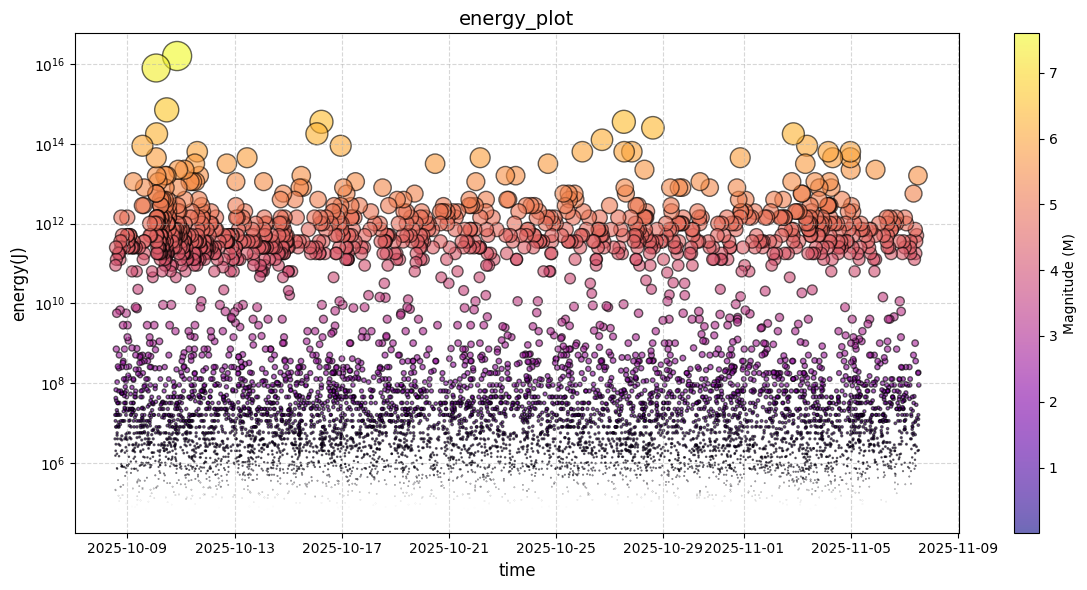

In [6]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

url = "https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_month.geojson"
data = requests.get(url).json()

records = []
for f in data["features"]:
    mag = f["properties"]["mag"]
    time = pd.to_datetime(f["properties"]["time"], unit="ms")
    depth = f["geometry"]["coordinates"][2]
    if mag and mag > 0:
        energy = 10 ** (1.5 * mag + 4.8)  
        records.append([time, mag, energy, depth])

df = pd.DataFrame(records, columns=["time", "mag", "energy", "depth"])


plt.figure(figsize=(12,6))
plt.scatter(df["time"], df["energy"], 
            c=df["mag"], s=df["mag"]**3, alpha=0.6, cmap="plasma", edgecolors="k")

plt.yscale("log")  
plt.colorbar(label="Magnitude (M)")
plt.title("energy_plot", fontsize=14)
plt.xlabel("time", fontsize=12)
plt.ylabel("energy(J)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [11]:
def classify(m):
    if m < 4:
        return "小規模（M<4）"
    elif m < 6:
        return "中規模（4≤M<6）"
    else:
        return "大規模（M≥6）"

df["category"] = df["magnitude"].apply(classify)

energy_sum = df.groupby("category")["energy"].sum()
energy_ratio = energy_sum / energy_sum.sum() * 100

print("=== 地震エネルギー総量（過去1か月） ===")
print(energy_sum.apply(lambda x: f"{x:.2e} J"))  
print("\n=== 割合（%） ===")
print(energy_ratio.round(2))

=== 地震エネルギー総量（過去1か月） ===
category
中規模（4≤M<6）    1.62e+15 J
大規模（M≥6）      2.68e+16 J
小規模（M<4）      1.95e+12 J
Name: energy, dtype: object

=== 割合（%） ===
category
中規模（4≤M<6）     5.70
大規模（M≥6）      94.30
小規模（M<4）       0.01
Name: energy, dtype: float64


発生件数では小規模地震が圧倒的に多いが、エネルギー総量では大規模地震が大半を占めることが分かった。
つまり、地震エネルギーは多数の小さな地震ではなく、わずかな大地震によってエネルギーの大部分を占めている。
これにより、マグニチュードという指数スケールが地震のエネルギー分布を理解する鍵であることがわかる。
また、マグニチュード6以上の地震が1回あるだけで、M4クラスの地震1000回分以上のエネルギーを放出してるとわかる。
地震の発生回数は日によってばらつくが、エネルギー量で見ると特定の日に突出した放出が起きている。これはその日に1件でも大きな地震（M6以上）が起きたことを示していると考えられる。